# DASC 512 - 25 - Multiple Comparisons

This lessons focuses on **making comparisons between many groups**. This is typically done as a post-hoc analysis from ANOVA.

***


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.graphics.api as smg
import statsmodels.formula.api as smf

sns.set_style('whitegrid')

In [2]:
# Importing the Coughing Kids example data again
dm = [4,6,9,4,7,7,7,9,12,10,11,6,3,4,9,12,7,6,8,12,12,4,12,13,7,10,13,9,4,4,10,15,9]
honey = [12,11,15,11,10,13,10,4,15,16,9,14,10,6,10,8,11,12,12,8,12,9,11,15,10,1,9,13,8,12,10,8,9,5,12]
placebo = [5,8,6,1,0,8,12,8,7,7,1,6,7,7,12,7,9,7,9,5,11,9,5,6,8,8,6,7,10,9,4,8,7,3,1,4,3]
labels = ['dm'] * len(dm) + ['honey'] * len(honey) + ['placebo'] * len(placebo)
scores = pd.DataFrame({'treatment':labels, 'score':dm+honey+placebo})

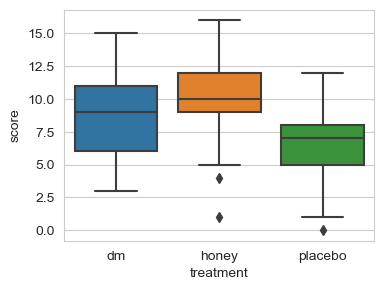

In [3]:
# Recall what this data looks like
fig, ax = plt.subplots(figsize=(4,3))
sns.boxplot(data=scores, x='treatment',y='score',ax=ax)
plt.show()

Recall the ANOVA we did. I'll re-import that short function from last lesson.

In [4]:
def anova(model):
    import statsmodels.stats.api as sms
    at = sms.anova_lm(model, typ=2)
    at['mean_sq'] = at['sum_sq'] / at['df']
    at = at.reindex(['df','sum_sq','mean_sq','F','PR(>F)'],axis=1)
    return at

In [5]:
# And recall the ANOVA
model = smf.ols('score ~ C(treatment)', data=scores).fit()
anova_table = anova(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(treatment),2.0,259.842471,129.921236,13.276934,0.000008
Residual,102.0,998.119434,9.785485,NaN,NaN


### Bonferroni

This is an easy one to implement manually, so let's try it.

In [6]:
scores.groupby('treatment').describe()

score                                                 
          count       mean       std  min  25%   50%   75%   max
treatment                                                       
dm         33.0   8.333333  3.256404  3.0  6.0   9.0  11.0  15.0
honey      35.0  10.314286  3.197163  1.0  9.0  10.0  12.0  16.0
placebo    37.0   6.513514  2.940348  0.0  5.0   7.0   8.0  12.0

In [8]:
alpha = 0.05
num_treatments = 3
alpha_bonf = alpha / math.comb(num_treatments,2)
alpha_bonf

0.016666666666666666

In [12]:
t, pval = stats.ttest_ind(a=dm, b=honey)
if pval < alpha_bonf:
    print(f'The p-value is {pval:.4f}, so we reject the null.')
else:
    print(f'The p-value is {pval:.4f}, so we fail to reject the null.')

The p-value is 0.0138, so we reject the null.


In [11]:
t, pval = stats.ttest_ind(a=dm, b=placebo)
if pval < alpha_bonf:
    print(f'The p-value is {pval:.4f}, so we reject the null.')
else:
    print(f'The p-value is {pval:.4f}, so we fail to reject the null.')

The p-value is 0.0166, so we reject the null.


In [13]:
t, pval = stats.ttest_ind(a=honey, b=placebo)
if pval < alpha_bonf:
    print(f'The p-value is {pval:.4f}, so we reject the null.')
else:
    print(f'The p-value is {pval:.4f}, so we fail to reject the null.')

The p-value is 0.0000, so we reject the null.


So all three pairs are different! Let's also look at the easy Python way to do this.

In [45]:
multi_comp = sms.multicomp.MultiComparison(data=scores['score'], groups=scores['treatment'])
print(multi_comp.allpairtest(testfunc=stats.ttest_ind, alpha=0.05, method='bonf')[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.02, alphacBonf=0.017
group1  group2   stat   pval  pval_corr reject
----------------------------------------------
    dm   honey -2.5307 0.0138    0.0413   True
    dm placebo  2.4572 0.0166    0.0497   True
 honey placebo  5.2543    0.0       0.0   True
----------------------------------------------


The columns in this table are mostly self-explanatory. The pval_corr is the corrected p-value - in Bonferroni, this is just the p-value multiplied by the number of groups. This allows you to compare to your original alpha if you prefer that.

Above the table, we also see the Family-Wise Error Rate (FWER), specified as alpha in the function, and the Bonferroni alpha (0.017). You can ignore the Sidak value, but it is similar to Bonferroni but assumes that each test is independent.

Note that this could be applied to other hypothesis test functions as well. For these pair-wise comparisons, we'd want to use the t-test.

**Warning**: My biggest complaint about this function is reporting of a p-value of 0. **The p-value should never be reported as zero!** That implies that it is *impossible* rather than *improbable* that this difference would happen by chance. Please replace this with "<0.0001" in any reports.

Let's explore that multi_comp.allpairtest() object more. As you see above, we called index 0 to get this table.

In [46]:
# Exploring multi_comp more...
mc = multi_comp.allpairtest(testfunc=stats.ttest_ind, alpha=0.05)
mc

(<class 'statsmodels.iolib.table.SimpleTable'>,
 (array([[-2.53071540e+00,  1.37750156e-02],
         [ 2.45721098e+00,  1.65579640e-02],
         [ 5.25432925e+00,  1.52878151e-06]]),
  array([ True,  True,  True]),
  array([4.13250468e-02, 4.96738920e-02, 4.58634453e-06]),
  0.016952427508441503,
  0.016666666666666666),
 array([('dm', 'honey', -2.5307, 0.0138, 0.0413,  True),
        ('dm', 'placebo',  2.4572, 0.0166, 0.0497,  True),
        ('honey', 'placebo',  5.2543, 0.    , 0.    ,  True)],
       dtype=[('group1', 'O'), ('group2', 'O'), ('stat', '<f8'), ('pval', '<f8'), ('pval_corr', '<f8'), ('reject', '?')]))

In [47]:
mc[0]

group1,group2,stat,pval,pval_corr,reject
dm,honey,-2.5307,0.0138,0.0413,True
dm,placebo,2.4572,0.0166,0.0497,True
honey,placebo,5.2543,0.0,0.0,True


In [42]:
mc[1]

(array([[-2.53071540e+00,  1.37750156e-02],
        [ 2.45721098e+00,  1.65579640e-02],
        [ 5.25432925e+00,  1.52878151e-06]]),
 array([ True,  True,  True]),
 array([4.13250468e-02, 4.96738920e-02, 4.58634453e-06]),
 0.016952427508441503,
 0.016666666666666666)

In [48]:
mc[2]

array([('dm', 'honey', -2.5307, 0.0138, 0.0413,  True),
       ('dm', 'placebo',  2.4572, 0.0166, 0.0497,  True),
       ('honey', 'placebo',  5.2543, 0.    , 0.    ,  True)],
      dtype=[('group1', 'O'), ('group2', 'O'), ('stat', '<f8'), ('pval', '<f8'), ('pval_corr', '<f8'), ('reject', '?')])

This format looks like a mess, but it's very useful. Turn this into a DataFrame to see that.

In [43]:
pd.DataFrame(mc[2])

,group1,group2,stat,pval,pval_corr,reject
0,dm,honey,-2.5307,0.0138,0.0413,True
1,dm,placebo,2.4572,0.0166,0.0497,True
2,honey,placebo,5.2543,0.0000,0.0000,True


Now that we have the table in a DataFrame, it's easy to copy it to the clipboard and paste it into Word, Excel, or your favorite software to make a nice-looking table.

In [44]:
pd.DataFrame(mc[2]).to_clipboard()

## Bonferroni-Holm

We'll use the same data to run Bonferroni-Holm.

In [49]:
mc = multi_comp.allpairtest(testfunc=stats.ttest_ind, alpha=0.05, method='Holm')

In [51]:
mc[0]

group1,group2,stat,pval,pval_corr,reject
dm,honey,-2.5307,0.0138,0.0276,True
dm,placebo,2.4572,0.0166,0.0276,True
honey,placebo,5.2543,0.0,0.0,True


In [50]:
pd.DataFrame(mc[2])

,group1,group2,stat,pval,pval_corr,reject
0,dm,honey,-2.5307,0.0138,0.0276,True
1,dm,placebo,2.4572,0.0166,0.0276,True
2,honey,placebo,5.2543,0.0000,0.0000,True


## Tukey's HSD (and Tukey-Kramer)

In [52]:
mc = multi_comp.tukeyhsd(alpha=0.05)

In [53]:
mc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
dm,honey,1.981,0.0279,0.1757,3.7862,True
dm,placebo,-1.8198,0.0441,-3.6013,-0.0384,True
honey,placebo,-3.8008,0.0,-5.5551,-2.0465,True


This is less easy to copy to the clipboard (though you can directly save it as a csv or output in LaTeX format).

In [79]:
tab = pd.DataFrame(mc.summary())
tab.columns = tab.iloc[0]
tab = tab[1:]
tab

,group1,group2,meandiff,p-adj,lower,upper,reject
1,dm,honey,1.981,0.0279,0.1757,3.7862,True
2,dm,placebo,-1.8198,0.0441,-3.6013,-0.0384,True
3,honey,placebo,-3.8008,0.0,-5.5551,-2.0465,True
